https://link.springer.com/content/pdf/10.1007%2F3-540-45054-8_27.pdf

In [1]:
import helper_func as hf
import cv2
import numpy as np
import pandas as pd
import os
from pprint import pprint 
from matplotlib import pyplot as plt

overview = os.path.join('.', 'data', 'overview')
focus = os.path.join('.', 'data', 'focus')
cnn = os.path.join('.', 'data', 'CNN_data')
cnn_cut = os.path.join('.', 'data', 'cnn_data_cut')

In [2]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

# settings for LBP
METHOD = 'uniform'
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

def create_images_with_filters(images, img_dict='img', img_name='name'):
    images_list = []
    for img in images:
        lbp = local_binary_pattern(img[img_dict], n_points, radius, METHOD)

        titles = ('edge', 'flat', 'corner')
        w = radius - 1
        edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
        flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
        i_14 = n_points // 4            # 1/4th of the histogram
        i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
        corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                        list(range(i_34 - w, i_34 + w + 1)))

        label_sets = (edge_labels, flat_labels, corner_labels)

        filtered_image = []
        for index, labels in enumerate(label_sets):
            filtered_image.append({
                "img": overlay_labels(img[img_dict], lbp, labels), 
                "label": titles[index] + img[img_name]
                })
        images_list.append(filtered_image)
    return images_list


def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))


def match(refs, img):
    best_score = 10
    best_name = None
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins,
                                   range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name


### Original brick data

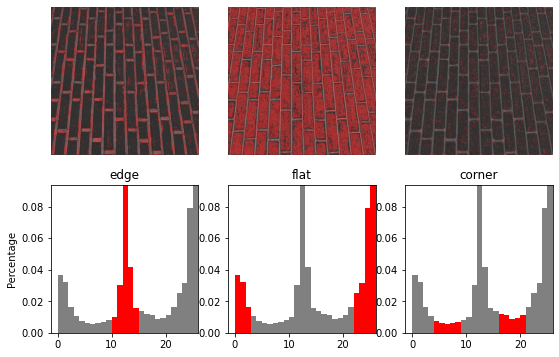

In [3]:
image = data.brick()
lbp = local_binary_pattern(image, n_points, radius, METHOD)

# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

### Show images with applied 3 filter (edge, flat, corner) for overview images

In [4]:
images = hf.load_data(overview, grayscale=True)
images_lbp = create_images_with_filters(images)

for image in images_lbp:
    hf.showCW(image, dict='img', label='label', type='cw_m')

Loaded (8) images from .\data\overview


### Create referense for positive and negative class and use it for classification

Loaded (97) images from .\data\cnn_data_cut


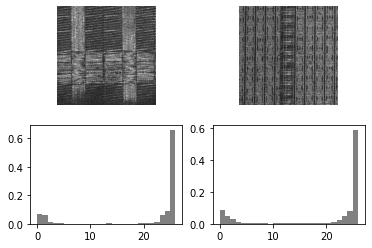

In [5]:
images = hf.load_data(cnn_cut, grayscale=True)
positive_train = list(filter(lambda x: x['name'] == '04_True_3x1.png', images))[0]['img']
negative_train = list(filter(lambda x: x['name'] == '07_False_1x1.png', images))[0]['img']

refs = {
    'positive': local_binary_pattern(positive_train, n_points, radius, METHOD),
    'negative': local_binary_pattern(negative_train, n_points, radius, METHOD),
}

# Create histogram for referenece data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(6, 4))
plt.gray()

ax1.imshow(positive_train)
ax1.axis('off')
hist(ax3, refs['positive'])

ax2.imshow(negative_train)
ax2.axis('off')
hist(ax4, refs['negative'])

plt.show()

Giving positive_test negative
Giving negative_test positive


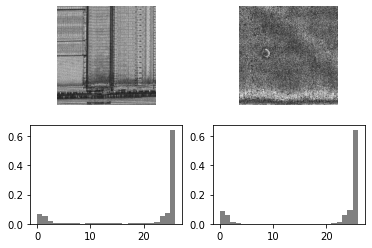

In [6]:
positive_test = list(filter(lambda x: x['name'] == '13_True_2x1.png', images))[0]['img']
negative_test = list(filter(lambda x: x['name'] == '02_False_3x2.png', images))[0]['img']

print('Giving positive_test', match(refs, positive_test))
print('Giving negative_test', match(refs, negative_test))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(6, 4))
plt.gray()

ax1.imshow(positive_test)
ax1.axis('off')
hist(ax3, local_binary_pattern(positive_test, n_points, radius, METHOD))

ax2.imshow(negative_test)
ax2.axis('off')
hist(ax4, local_binary_pattern(negative_test, n_points, radius, METHOD))

plt.show()